In [21]:
import numpy as np
import torch
import torch.nn as nn
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", myDevice)

from kalman_filter import *
from helpers import *
from plotting import *
from trajectories import *

T = 250 # how long to simulate the trajectory

Using device cpu


Trajectory shape (250, 2)
Measured shape (250, 2)


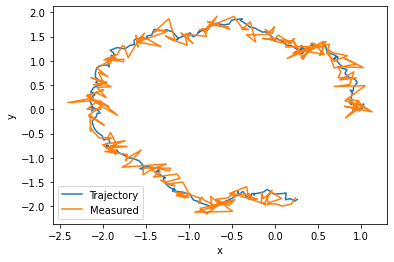

In [22]:
# See if you can feed numbers through the transformer and get it to spit out the right stuff

task_name = 'so2' # Choose from 'so2', 'motion', 'so3', 'accel', 'smd'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]()
num_traj = 20 # How many to test on
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

In [23]:
from transformers import GPT2Model, GPT2Config

class TransformerModel(nn.Module):
    def __init__(self, n_input, n_positions, n_output=1, n_embd=128, n_layer=12, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_input
        
        self._read_in = nn.Linear(n_input, n_embd)
        # print("readin", self._read_in)
        self._backbone = GPT2Model(configuration)
        # print("backbone", self._backbone)
        self._read_out = nn.Linear(n_embd, n_output)
        # print("readout", self._read_out)

    def forward(self, traj):
        embeds = self._read_in(traj)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state
        prediction = self._read_out(output)
        return prediction

In [24]:
from transformers import GPT2Model, GPT2Config
import yaml

class Struct:
    def __init__(self, **entries): 
        self.__dict__.update(entries)

with open("models/small.yaml", 'r') as yaml_file:
    try: f = yaml.safe_load(yaml_file)
    except yaml.YAMLError as exc: print(exc)

conf = Struct(**f['model'])

model = TransformerModel(
            n_input=state_dim + input_dim,
            n_positions=T,
            n_output=obs_dim,
            n_embd=conf.n_embd,
            n_layer=conf.n_layer,
            n_head=conf.n_head,
        )

model.train() # put the model in training mode - will pass gradients through

print(model)

TransformerModel(
  (_read_in): Linear(in_features=3, out_features=128, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(250, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout

In [36]:
num_iterations = 100
batch_size = 100

loss_func = torch.nn.MSELoss(reduction="sum")

optimizer = torch.optim.Adam(model.parameters())
losses = []

for i in range(num_iterations):
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # For now, just use a single datapoint so that it is nice and easy to work with.
#     u_batch = u_batch[0]
#     traj_batch = traj_batch[0]
#     meas_batch = meas_batch[0]
    
    # Cast to PyTorch tensors
    target_sequences_train = torch.from_numpy(meas_batch).to(myDevice) # trying to hit noisy data
    input_sequences_train = torch.from_numpy(u_batch).to(myDevice)
    
    print("target", target_sequences_train.shape)
    print("input", input_sequences_train.shape)
    # input_train is shape [batch_size, seq_len, state_dim + input_dim]. Concatenate noisy data and inputs.
    transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
#     print("shape", transformer_input_train.shape)
    
    # transformer_input_train is shape [state_dim + input_dim, seq_len, batch_size]
#     print("transformer_input_train, single input", transformer_input_train.shape)
    
    # Run through the GPT model
    decoder_output = model(transformer_input_train)
    print("Decoder output", decoder_output.shape)

    # Compute Loss and Backpropagate
    loss = loss_func(decoder_output, target_sequences_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    curr_loss = loss.item()
    losses.append(curr_loss)
    
    print('Iteration', i, ": Loss", curr_loss)

target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 0 : Loss 629.106974151596
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 1 : Loss 13848.452206465681
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 2 : Loss 1305.957767033729
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 3 : Loss 2563.598477488781
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 4 : Loss 4503.554526840076
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 5 : Loss 5096.643651257535
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 6 : Loss 4582.50055966884


target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 57 : Loss 28.993635091582153
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 58 : Loss 33.246682413935844
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 59 : Loss 39.34494384958442
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 60 : Loss 22.970750720282243
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 61 : Loss 28.185007719702355
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 62 : Loss 34.804890239807
target torch.Size([100, 250, 2])
input torch.Size([100, 250, 1])
Decoder output torch.Size([100, 250, 2])
Iteration 63 : Loss 22.15952

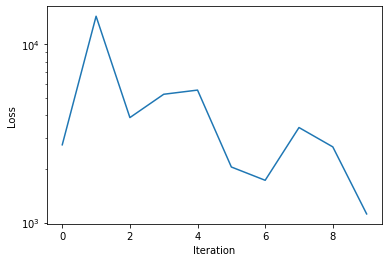

In [34]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
# plt.xscale("log")

plt.show()

myMeas torch.Size([250, 2])
myUseq torch.Size([250, 1])
myMeas tensor([[ 1.0829e+00, -7.0580e-03],
        [ 9.6568e-01,  1.0488e-01],
        [ 1.1270e+00, -5.2826e-02],
        [ 8.0402e-01,  6.1209e-02],
        [ 9.2842e-01,  2.5934e-02],
        [ 9.5304e-01,  1.6962e-01],
        [ 1.0236e+00,  7.3228e-02],
        [ 8.1516e-01, -1.7650e-01],
        [ 9.6669e-01,  7.0171e-02],
        [ 8.7388e-01,  1.6419e-01],
        [ 9.3583e-01,  2.5766e-02],
        [ 9.8604e-01, -3.2791e-02],
        [ 8.9461e-01,  2.4290e-02],
        [ 9.7396e-01,  1.7250e-01],
        [ 8.4486e-01,  2.0908e-01],
        [ 9.4335e-01,  9.4596e-02],
        [ 8.1114e-01,  1.7938e-01],
        [ 1.0459e+00,  4.8721e-01],
        [ 6.8480e-01,  4.6906e-01],
        [ 8.6710e-01,  5.1085e-01],
        [ 9.1369e-01,  7.7375e-01],
        [ 7.4992e-01,  6.0674e-01],
        [ 9.4363e-01,  6.4628e-01],
        [ 7.3048e-01,  6.5328e-01],
        [ 7.6315e-01,  7.7150e-01],
        [ 7.2432e-01,  8.7722e-01],
 

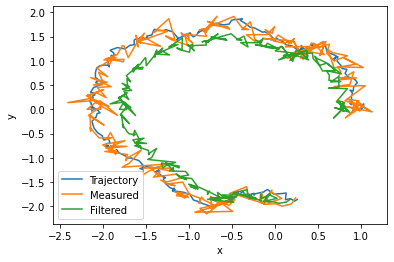

In [35]:
myMeas = torch.tensor(meas[0])
myUseq = torch.tensor(u_seq[0])
print("myMeas", myMeas.shape)
print("myUseq", myUseq.shape)

transformer_input = torch.cat((myMeas, myUseq), dim=1)
fltr = model(transformer_input).detach().numpy()

print("myMeas", myMeas)
print("filtered", fltr)

plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': fltr})